In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command


In [2]:
class State(TypedDict):
    """
    Represents a state with a specific structure defined in a TypedDict.

    Defines the `State` class which incorporates structured data for maintaining
    a state, ensuring compliance with specific annotations to the data.

    :ivar message: A list that holds the message data. The structure of this list
        adheres to annotations specified by the `add_messages`.
    :type message: Annotated[list, add_messages]
    """
    messages: Annotated[list, add_messages]

In [3]:
@tool
def get_stock_price(symbol: str) -> float:
    """return stock price for a given symbol stock symbol
    :param symbol:
    :return:  current stock price
    """
    return {
        "MSFT": 970.3,
        "AAPL": 1506.3,
        "GOOG": 1840.3,
        "AMZN": 899.3,
        "FB": 540.3,
        "TSLA": 870.3
    }.get(symbol, 0.0)

@tool
def buy_stocks(symbol: str, quantity: int, total_price: float) -> str:
    '''Buy stocks given the stock symbol and quantity'''
    decision = interrupt(f"Approve buying {quantity} {symbol} stocks for ${total_price:.2f}?")

    if decision == "yes":
        return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    else:
        return "Buying declined."


tools = [get_stock_price, buy_stocks]

llm = init_chat_model("google_genai:gemini-2.5-flash")
llm_with_tools = llm.bind_tools(tools)

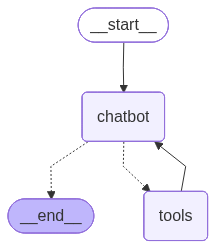

In [4]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


memory = MemorySaver()
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)


graph = builder.compile(checkpointer=memory)

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": "buy_thread"}}

# Step 1: user asks price
state = graph.invoke({"messages":[{"role":"user","content": "What is the current price of 10 MSFT stocks?"}]}, config=config)

print(state["messages"][-1].content)

The current price of 10 MSFT stocks is 9703.0.


In [6]:
msg = "Buy 10 MSFT stocks at current price."
# Step 2: user asks to buy
state = graph.invoke({"messages":[{"role":"user","content": msg}]}, config=config)
print(state.get("__interrupt__"))

[Interrupt(value='Approve buying 10 MSFT stocks for $9703.00?', id='a9c7df47f1c67c9cc4ec1e794a833f2e')]


In [7]:
decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config)
print(state["messages"][-1].content)

Buying declined.
